In [2]:
using PyPlot
using Roots
using NLsolve
using DataFrames
using PyCall

In [3]:
using IMinuit

In [4]:
PyPlot.svg(false)

false

In [5]:
include("./src/lattice_data.jl")
include("./src/latt_para.jl")
include("./src/tmat_finite_vol.jl")
include("./src/tmat_finite_vol_nlo.jl")

pole_finite_vol_nlo! (generic function with 1 method)

In [6]:
latt_para = lattice_params()

Dict{Symbol, Any} with 5 entries:
  :m_meson    => (203.655, 486.366)
  :threshold  => [1397.59, 1466.14, 1683.94, 1781.53]
  :decons_vec => [93.1531, 108.23, 119.217, 108.23]
  :L          => 0.0205243
  :mch        => [(203.655, 1193.94), (486.366, 979.777), (551.1, 1132.84), (48…

# Energy level

At leading order s wave, we only consider two-energy level. For higher energy levels, we should include p wave.

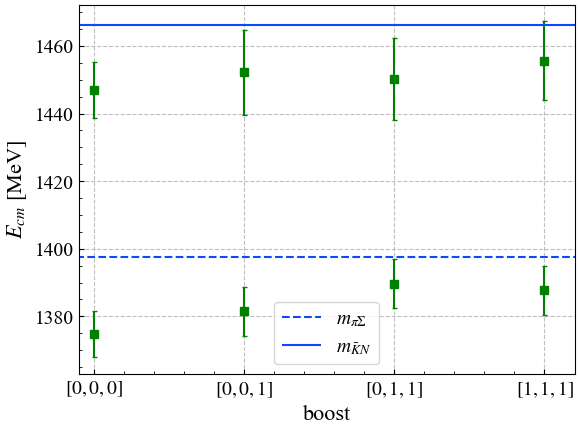

In [7]:
fig, ax = PyPlot.subplots()
plot_latt_ener_2level!(ax, _2lv, _2lv_err, latt_para[:threshold] )
ax.grid()
gcf()

In [8]:
function cost_fun!(latt_pole, latt_pole_err, params, Nv, fitted_para; dof=2,  fix_f=false)
    para = copy(params)
    if fix_f == true
        a1, a2, f, fπ = fitted_para
        
        para[:decons_vec] = [fπ fπ*f; fπ*f fπ]
    else
        a1, a2 = fitted_para
    end

    dd = 0e0
    len = 0e0
    for (pole, pole_err, N) in zip(latt_pole, latt_pole_err, Nv)
        p = []
        df1 = bisection_internal_sol!(x -> tdet_finite_vol_params!(x, para, [a1, a2], N), 1350, 1400, 1)
        df2 = bisection_internal_sol!(x -> tdet_finite_vol_params!(x, para, [a1, a2], N), 1420, 1468, 1)
        x10 = df1.x0
        x20 = df2.x0

        if length(x10) == 1
            append!(p, x10)
        else
            append!(p, pole_finite_vol!(1380, para, [a1, a2], N))
        end
        
        if length(x20) == 1
            append!(p, x20)
        else
            append!(p, pole_finite_vol!(1466, para, [a1, a2], N) )
        end
        
        d = (pole - p) ./ pole_err
        dd += d' * d
        len += length(pole)
    end
    return dd / (len - dof)
end

Nv = [[0,0,0], [0,0,1],[0,1,1],[1,1,1]]

function makefit_finite_lo!(costfun, init_para)
    m = Minuit(costfun, init_para, limit_x0=(-5, -0.1), limit_x1=(-5, -0.1))
    m.strategy = 2
    migrad(m)
    migrad(m)
end

#m = makefit_finite_lo!(f -> cost_fun!(_2lv, _2lv_err, params, Nv, f), [-1.6325762046840782, -1.7138485812778343])

makefit_finite_lo! (generic function with 1 method)

In [9]:
params = copy(latt_para)
f = 1.1999999988821624
fπ = 93

#params[:decons_vec] = [fπ fπ*f; fπ*f fπ]#[92.4, 92.4, 92.4, 92.4] .* 1.2
params[:decons_vec] = [fπ, 108e0]

2-element Vector{Float64}:
  93.0
 108.0

In [10]:
#a_fit = [m.values...]
 a_fit = [-1.6325807018101615, -1.7138494070912544]

2-element Vector{Float64}:
 -1.6325807018101615
 -1.7138494070912544

  1.376613 seconds (14.23 M allocations: 589.139 MiB, 6.38% gc time, 74.86% compilation time)


  0.771421 seconds (23.83 M allocations: 671.494 MiB, 7.47% gc time, 2.58% compilation time)


  0.750161 seconds (23.82 M allocations: 667.350 MiB, 7.29% gc time)


  0.759776 seconds (23.93 M allocations: 669.711 MiB, 7.50% gc time)


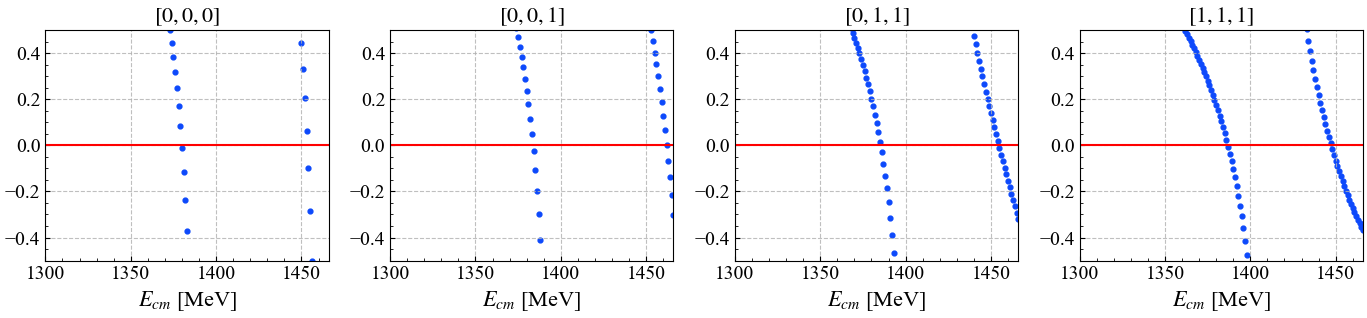

In [11]:
w = 1300:1:1466
fig, ax = PyPlot.subplots(1, 4, figsize=(14, 3.5), tight_layout=true)
title = [L"$[0,0,0]$", L"$[0,0,1]$", L"$[0,1,1]$", L"$[1,1,1]$"]
for (i, G) in enumerate([[0,0,0], [0,0,1],[0,1,1],[1,1,1]] )
    ax[i].set_title(title[i])
    @time plot_tdet_finite_vol!(ax[i], w, params, a_fit, G)
end
gcf()

In [12]:
@time bisection_internal_sol!(x -> tdet_finite_vol_params!(x, params, a_fit, [0, 1, 1]), 1350, 1466, 1)

  4.495369 seconds (57.89 M allocations: 1.977 GiB, 7.16% gc time, 66.33% compilation time)


Row,bis_inter,bis_x0,x0
,Any,Any,Any
1,"(1385, 1386)",1385.32,1385.32
2,"(1454, 1455)",1454.62,1454.62


In [13]:
function pole_finite_LO_2lv_bisection!(params, a, Nv)
    p = DataFrame([])
    columns = ["[0, 0, 0]", "[0, 0, 1]", "[0,1,1]", "[1,1,1]"]

    for (i, N) in enumerate(Nv)
        df = bisection_internal_sol!(x -> tdet_finite_vol_params!(x, params, a, N), 1350, 1470, 1)
        x0 = df.x0
        p[!, columns[i] ] = x0
    end
    #pp = DataFrame(p, ["[0,0,0]", "[0,0,1]", "[0,1,1]", "[1,1,1]"])
    return p
end
df = pole_finite_LO_2lv_bisection!(params, a_fit, Nv)
pole = [df[1:2, i] for i in 1:4]
df

Row,"[0, 0, 0]","[0, 0, 1]","[0,1,1]","[1,1,1]"
,Any,Any,Any,Any
1,1379.89,1383.65,1385.32,1386.8
2,1453.41,1462.04,1454.62,1447.35


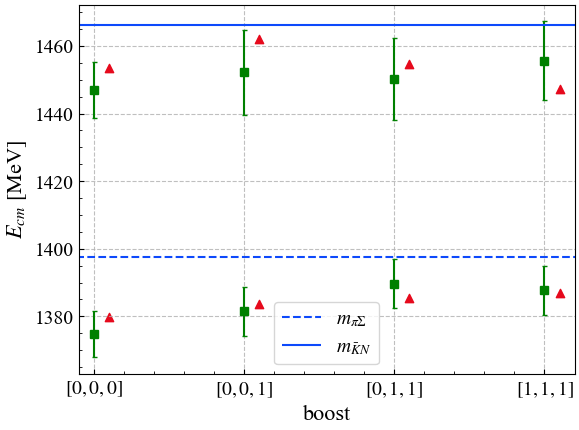

In [14]:
fig, ax = PyPlot.subplots()
plot_theory_ener_2level!(ax, pole)
plot_latt_ener_2level!(ax, _2lv, _2lv_err, latt_para[:threshold] )
ax.grid()
fig.savefig("./figure/two_energy_level_fitted.pdf")
gcf()

# 4 energy levels

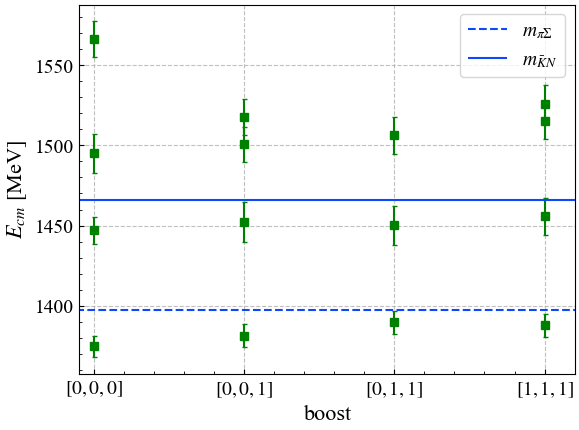

In [15]:
fig, ax = PyPlot.subplots()
#plot_theory_ener_2level!(ax, pole)
plot_latt_ener!(ax, latt_pole, latt_pole_err, latt_para[:threshold] )
ax.grid()
gcf()

We try to fit to all energy levels.

In [29]:
function cost_fun!(latt_pole, latt_pole_err, params, Nv, fitted_para; dof=2,  fix_f=false)
    para = copy(params)
    if fix_f == true
        a1, a2, f, fπ = fitted_para
        
        para[:decons_vec] = [fπ fπ*f; fπ*f fπ]
    else
        a1, a2 = fitted_para
    end

    dd = 0e0
    len = 0e0
    for (pole, pole_err, N) in zip(latt_pole, latt_pole_err, Nv)
        x0 = [pole_finite_vol!(init_x, para, [a1, a2], N) for init_x in pole]
        d = (pole - x0) ./ pole_err
        dd += d' * d
        len += length(pole)
    end
    return dd / (len - dof)
end

Nv = [[0,0,0], [0,0,1],[0,1,1],[1,1,1]]

function makefit_finite_lo!(costfun, init_para)
    m = Minuit(costfun, init_para, fix_x0 = true)
    m.strategy = 2
    migrad(m)
    migrad(m)
end
#-1.4606403424973218, -2.0
cost_fun!(latt_pole, latt_pole_err, params, Nv, [-1.1606403424973218, -2.0]; dof=2,  fix_f=false)

1.4651496936530235

In [18]:
function one_sigma_err_band!(cf; a1=-1.4606403424973218, a2=[])
    
end

one_sigma_err_band! (generic function with 1 method)

In [30]:
m = makefit_finite_lo!(f -> cost_fun!(latt_pole, latt_pole_err, params, Nv, f), [-1.4606403424973218, -2.0])

PyObject <FMin algorithm='Migrad' edm=1.3269038121886518e-12 edm_goal=0.0002 errordef=1.0 fval=1.1212432732579691 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=56 ngrad=0 reduced_chi2=nan time=-24.14297016710043>
(Param(number=0, name='x0', value=-1.8586995447267538, error=0.8080725368515922, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None), Param(number=1, name='x1', value=-2.0, error=0.02, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None))
[[0.65298122 0.        ]
 [0.         0.        ]]

In [32]:
[m.values...]

2-element Vector{Float64}:
 -1.8586995447267538
 -2.0

  0.613127 seconds (18.14 M allocations: 590.701 MiB, 11.53% gc time)


  1.340293 seconds (41.39 M allocations: 1.133 GiB, 9.74% gc time)


  1.344621 seconds (41.50 M allocations: 1.136 GiB, 9.73% gc time)


  1.348877 seconds (41.69 M allocations: 1.139 GiB, 9.42% gc time)


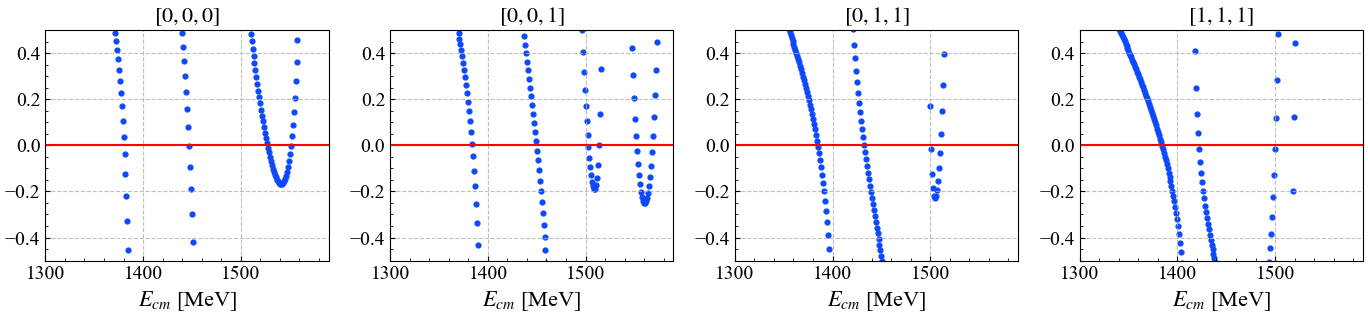

In [21]:
w = 1300:1:1590
fig, ax = PyPlot.subplots(1, 4, figsize=(14, 3.5), tight_layout=true)
title = [L"$[0,0,0]$", L"$[0,0,1]$", L"$[0,1,1]$", L"$[1,1,1]$"]
for (i, G) in enumerate([[0,0,0], [0,0,1],[0,1,1],[1,1,1]] )
    ax[i].set_title(title[i])
    @time plot_tdet_finite_vol!(ax[i], w, params, [-1.4606403424973218, -2.3], G)
end
gcf()

In [22]:
df2 = pole_finite_vol_all_boost!(latt_pole, params, [-1.4606403424973218, -2.0], Nv)
pole2 = [df2[!, i] for i in 1:4]
df2

Row,"[0, 0, 0]","[0, 0, 1]","[0,1,1]","[1,1,1]"
,Float64,Float64,Float64,Any
1,1380.86,1384.72,1386.36,1387.48
2,1450.89,1457.14,1444.97,1435.54
3,1533.69,1505.08,1511.95,1500.24
4,1554.0,1514.49,NaN,1519.66


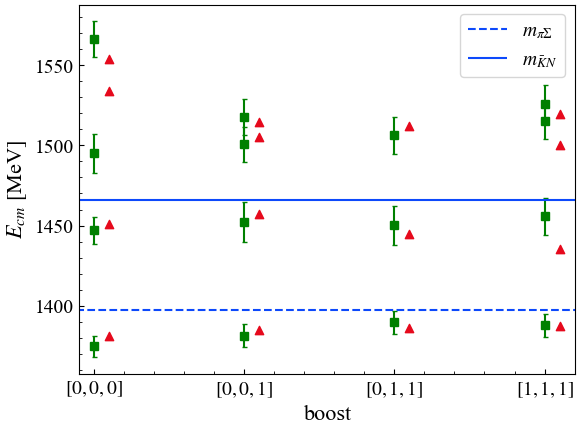

In [23]:
fig, ax = PyPlot.subplots()
plot_latt_ener!(ax, latt_pole, latt_pole_err, latt_para[:threshold] )
plot_theory_ener!(ax, pole2)
gcf()